# SIR modelling whole population

## Install packages

In [71]:
# https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html
# Created by Jeremy Cruz - https://code.sololearn.com/c4gmt97Se5f9/?ref=app

import subprocess
import sys

def install(package):
    subprocess.call([
        sys.executable, "-m", "pip", "-q", "install", package
    ])

install('gspread')
install('oauth2client')

## Define global helper functions

In [72]:
def convert_to_int(list):
    return [int(item) for item in list]

def get_range(start_date, end_date, list, date_list):
    start_index = date_list.index(start_date)
    end_index = date_list.index(end_date) + 1
    
    return list[start_index : end_index]

## Pull Covid-19 data from an excel spreadsheet

In [73]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

client = gspread.authorize(creds)

sheet = client.open('Denmark Covid-19 Data').get_worksheet(0)

## Modify excel data

In [74]:
date_full_column = sheet.col_values(1)   # Column A
s_full_column = sheet.col_values(2)      # Column B
i_full_column = sheet.col_values(3)      # Column C
r_full_column = sheet.col_values(4)      # Column D

test_full_column = sheet.col_values(14)  # Column 

 # Remove first line of each column
date_full_column.pop(0)
s_full_column.pop(0)
i_full_column.pop(0)
r_full_column.pop(0)
test_full_column.pop(0)

s_full_column = convert_to_int(s_full_column)
i_full_column = convert_to_int(i_full_column)
r_full_column = convert_to_int(r_full_column)

test_full_column = convert_to_int(test_full_column)

## Finding alpha and beta paremeters

In [102]:
params_interval_start = input('Enter a date in format of DD/MM/YYYY for finding beta and alpha: ')
# Default: 14/3/2020
params_interval_length = int(input('Enter how many days to capture for beta and alpha: ')) + 1
# Default: 14
    
params_date_start_index = date_full_column.index(params_interval_start)
params_date_end_index = params_date_start_index + params_interval_length

params_date_column = date_full_column[params_date_start_index : params_date_end_index]
params_s_column = s_full_column[params_date_start_index : params_date_end_index]
params_i_column = i_full_column[params_date_start_index : params_date_end_index]
params_r_column = r_full_column[params_date_start_index : params_date_end_index]

params_n = params_s_column[0] + params_i_column[0] + params_r_column[0]

Enter a date in format of DD/MM/YYYY for finding beta and alpha: 14/4/2020
Enter how many days to capture for beta and alpha: 15


In [103]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

params_x = np.array(range(params_interval_length))
params_y = np.log(params_i_column)

p = np.polyfit(params_x, params_y, 1)

m = p[0]  # Slope
b = p[1]  # Intersection at x = 0

alfa = (params_r_column[-1] - params_r_column[0]) / ((params_interval_length - 1) * params_i_column[0])

params_s_average = sum(params_s_column) / len(params_s_column)

beta = (params_n / params_s_average) * (alfa + m)

print('Alfa =', alfa, ', Beta =', beta, m)
print("y = %fx + %f" % (m,b))
print(params_n)

Alfa = 0.07204039311153188 , Beta = 0.034911419218932295 -0.037175722203607604
y = -0.037176x + 8.184480
5822763


<IPython.core.display.Javascript object>


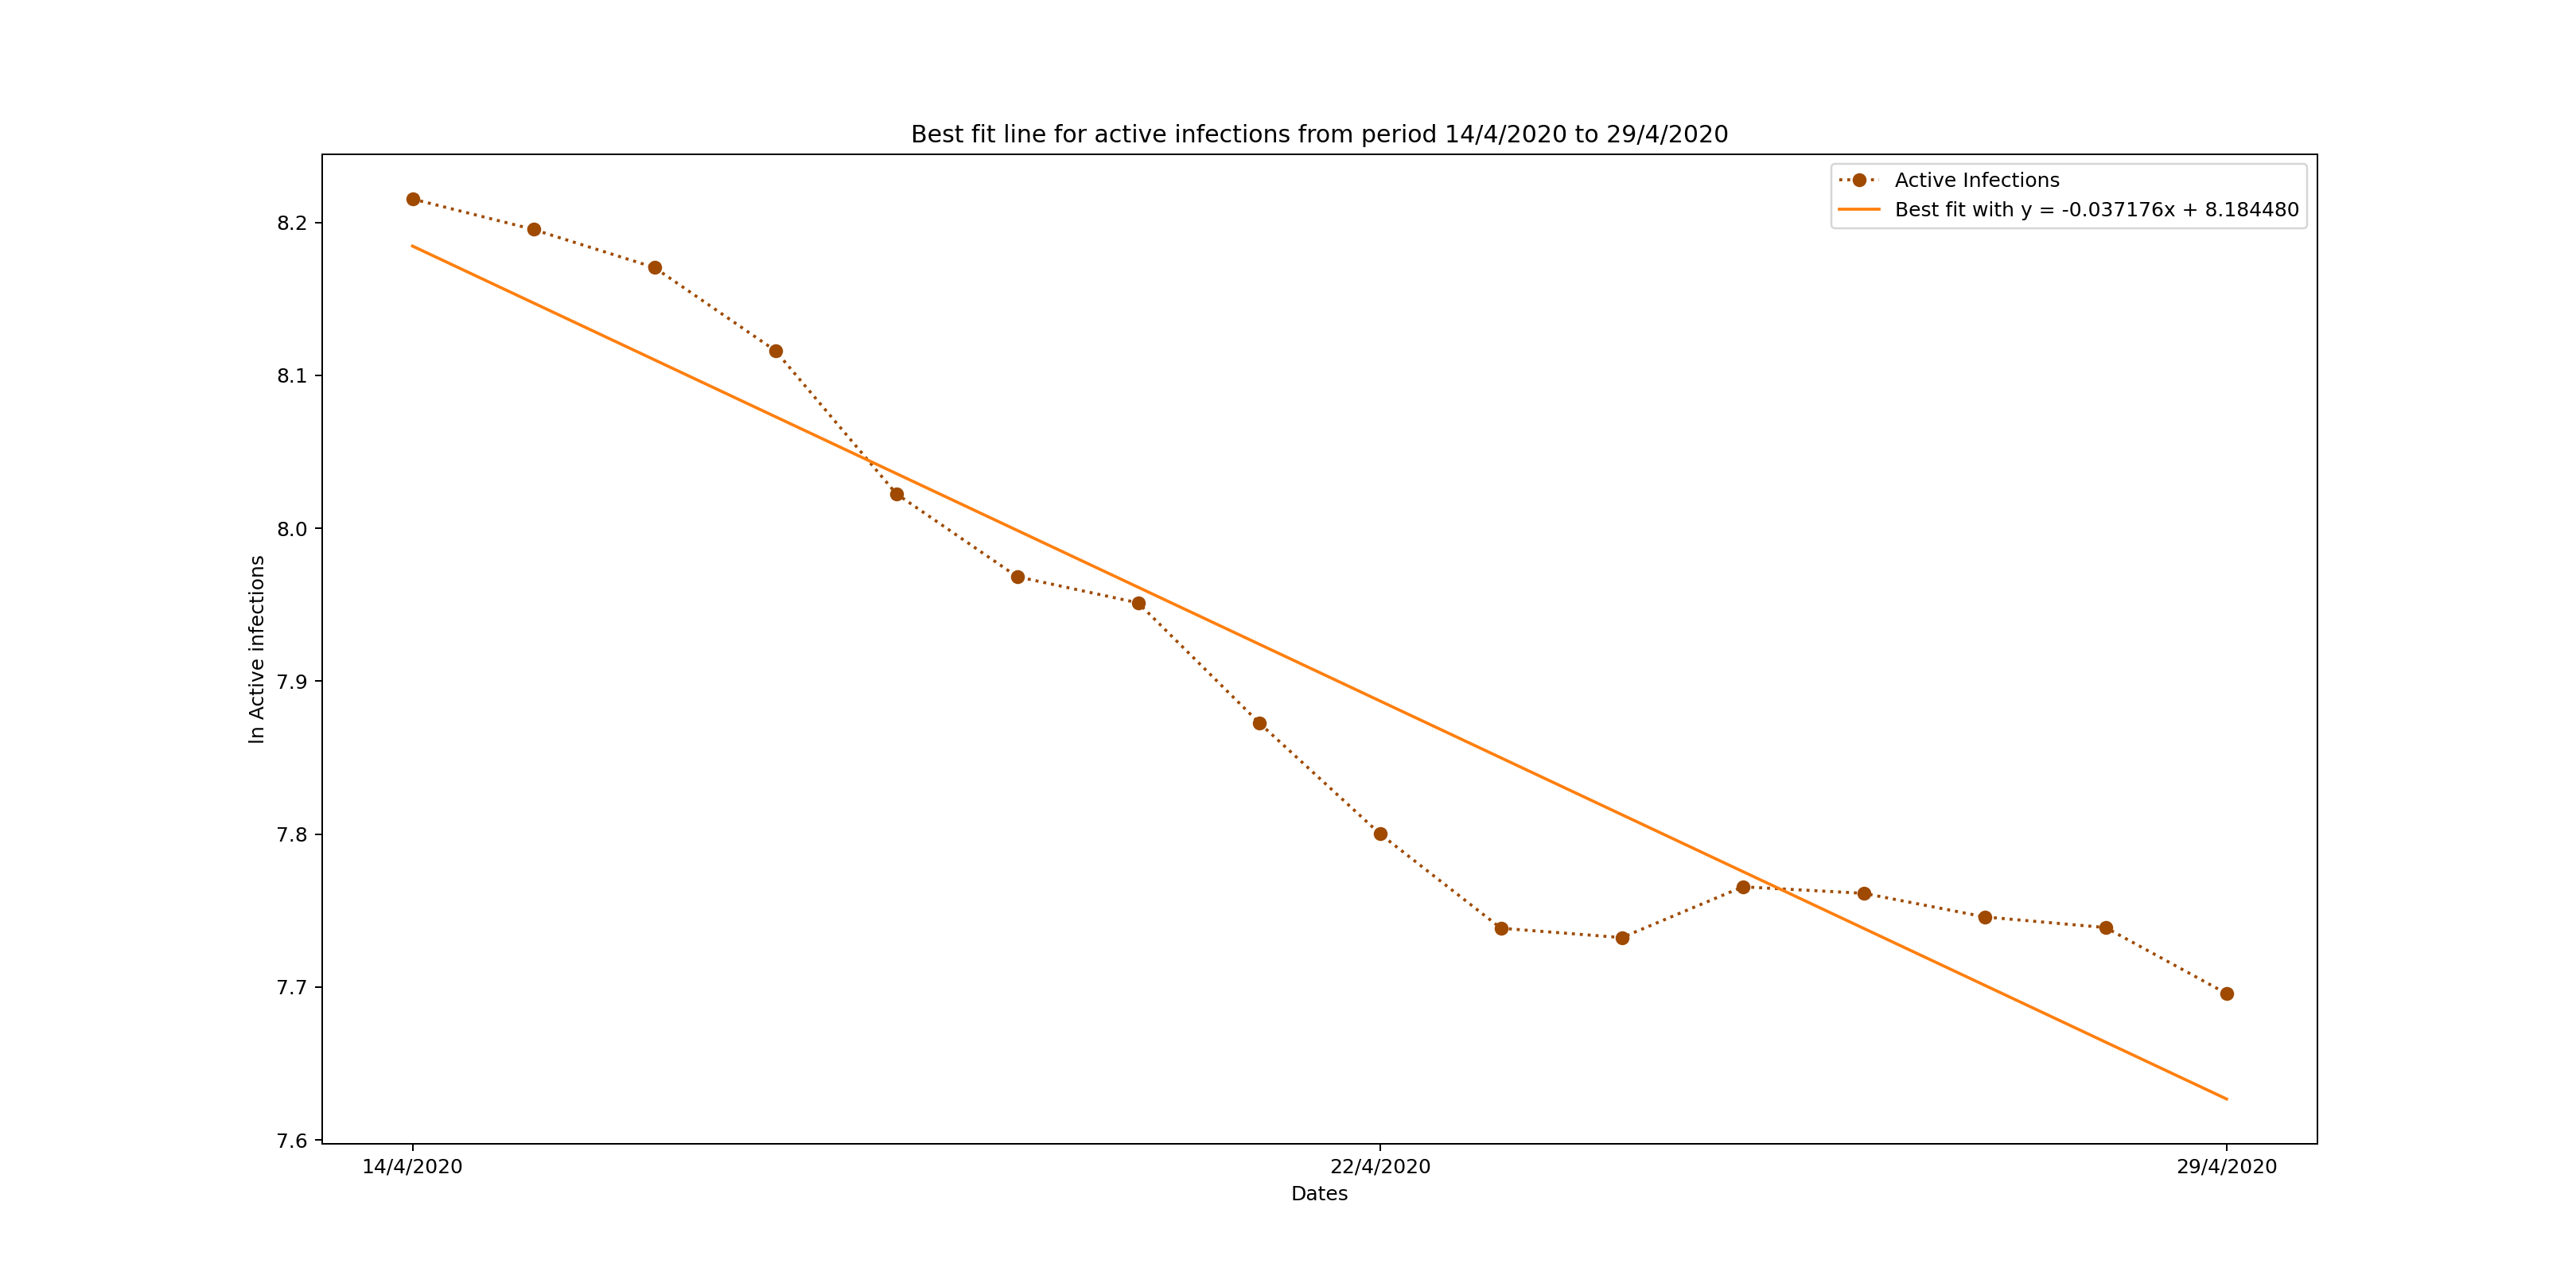

In [104]:
params_x_fit = np.arange(0, params_interval_length, 1)
params_y_fit = np.polyval(p, params_x_fit)

plt.figure(figsize = (10, 5))

plt.title('Best fit line for active infections from period ' + params_date_column[0] + ' to ' + params_date_column[-1])

plt.plot(params_date_column, params_y, ':o', label = 'Active Infections', color = '#9F4A00')
plt.plot(params_date_column, params_y_fit, '-', label = "Best fit with y = %fx + %f" % (m,b), color = '#FF7F0E')
xticks = [params_date_column[0], params_date_column[int(len(params_date_column) / 2)], params_date_column[-1]]
plt.legend()
plt.xticks(xticks, visible = True, rotation = "horizontal")
# plt.xticks(rotation = 17)

plt.xlabel('Dates')
plt.ylabel('ln Active infections')

if not os.path.exists('./Images'):
    os.makedirs('./Images')

plt.savefig('./Images/best_fit.png')
plt.show()

## Testing beta and alpha paremeters with different date intervals

In [105]:
graph_count = int(input('Enter how many date intervals to test beta and alpha with: '))

graphs = []

# Defaults

#2

# 14/3/2020
# 30

# 9/9/2021
# 16

for graph_index in range(graph_count):
    print('\n', graph_index + 1)
    start_date = input('Enter a date in format of DD/MM/YYYY for the start of the interval: ')
    interval_length = int(input('Enter how many days to capture: '))
    
    graphs.append({
        'date': start_date,
        'length': interval_length
    })

Enter how many date intervals to test beta and alpha with: 1

 1
Enter a date in format of DD/MM/YYYY for the start of the interval: 14/4/2020
Enter how many days to capture: 32


<IPython.core.display.Javascript object>


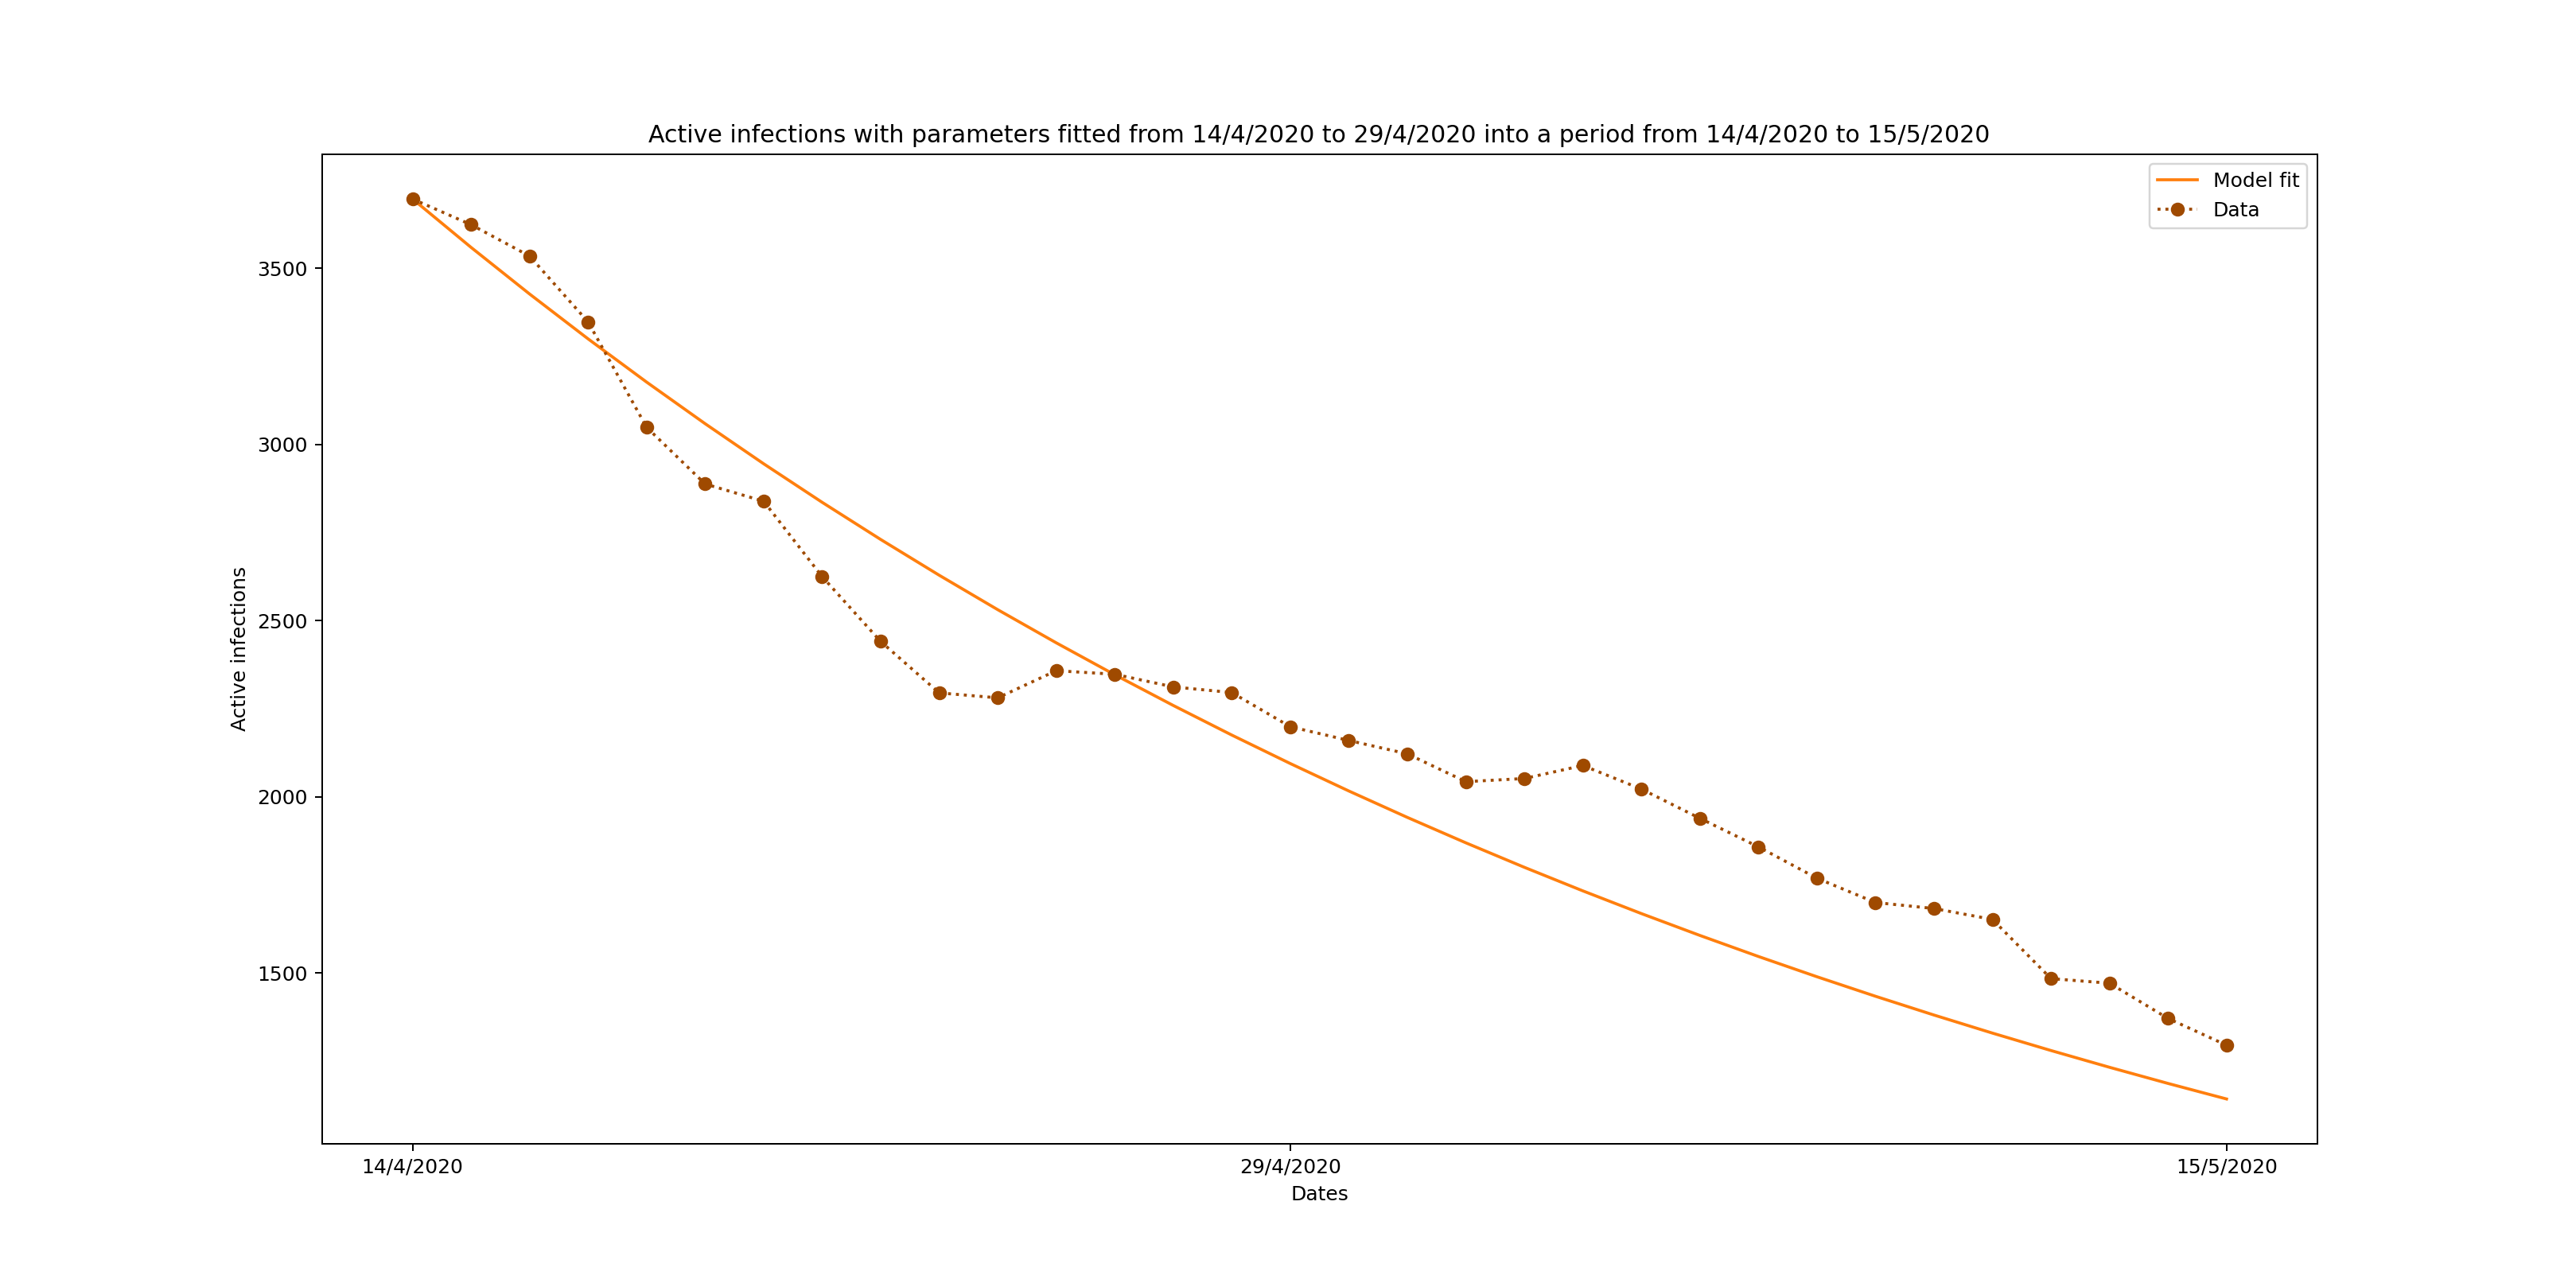

In [106]:
import math

for graph_index in range(graph_count):
    graph = graphs[graph_index]

    graph_start_index = date_full_column.index(graph['date'])
    graph_end_index = graph_start_index + graph['length']

    date_column = date_full_column[graph_start_index : graph_end_index]
    s_column = convert_to_int(s_full_column[graph_start_index : graph_end_index])
    i_column = convert_to_int(i_full_column[graph_start_index : graph_end_index])
    r_column = convert_to_int(r_full_column[graph_start_index : graph_end_index])

    # SIR initial values
    sir_n = s_column[0] + i_column[0] + r_column[0]
   
    sir_s = s_column[0] # Susceptibles
    sir_i = i_column[0] # Infected
    sir_r = r_column[0] # Recovered
 
    sir_s_list = [sir_s]
    sir_i_list = [sir_i]
    sir_r_list = [sir_r]

    for index in range(graph['length'] - 1): # Length - 1 because there are initial values
        sir_s_rate = -1 * sir_s * sir_i * beta / sir_n
        sir_i_rate = (sir_s * sir_i * beta / sir_n) - (sir_i * alfa)
        sir_r_rate = sir_i * alfa

        sir_s += sir_s_rate
        sir_i += sir_i_rate
        sir_r += sir_r_rate

        sir_s_list.append(sir_s)
        sir_i_list.append(sir_i)
        sir_r_list.append(sir_r)
        
    xticks = [date_column[0], date_column[int(len(date_column) / 2)], date_column[-1]]
    
    xticks = [date_column[0], date_column[15], date_column[-1]]
  
    if not os.path.exists('./Images'):
        os.makedirs('./Images')
    
#     # Plotting susceptibles
#     plt.figure(figsize = (10, 5))
#     plt.title('Susceptibles with parameters fitted from ' + params_date_column[0] + ' to '
#         + params_date_column[-1] + ' into a period from ' + date_column[0] + ' to ' + date_column[-1])
#     plt.plot(date_column, sir_s_list, '-', label = 'Model fit', color = '#1F77B4')
#     plt.plot(date_column, s_column, ':o', label = 'Data', color = '#154F7C')
#     plt.legend()
  
#     plt.ylabel('Susceptibles')
#     plt.xlabel('Dates')
   
#     plt.xticks(xticks, visible = True, rotation = "horizontal")

#     plt.savefig('./Images/susceptibles_' + 'graph_' + str(graph_index) + '.png')

#     plt.show()
       
#     print(math.exp(1))
    # Plotting active infections
    plt.figure(figsize = (10, 5))
    plt.title('Active infections with parameters fitted from ' + params_date_column[0] + ' to '
        + params_date_column[-1] + ' into a period from ' + date_column[0] + ' to ' + date_column[-1])
    plt.plot(date_column, sir_i_list, '-', label = 'Model fit', color = '#FF7F0E')
    plt.plot(date_column, i_column, ':o', label = 'Data', color = '#9F4A00')
    plt.legend()
#     plt.yscale('log', base=math.exp(1))
  
    plt.ylabel('Active infections')
    plt.xlabel('Dates')
   
    plt.xticks(xticks, visible = True, rotation = "horizontal")
#     plt.xticks(rotation = 17)

    plt.savefig('./Images/infected_' + 'graph_' + str(graph_index) + '.png')

    plt.show()
    
#     # Plotting recovered
#     plt.figure(figsize = (10, 5))
#     plt.title('Recovered with parameters fitted from ' + params_date_column[0] + ' to '
#         + params_date_column[-1] + ' into a period from ' + date_column[0] + ' to ' + date_column[-1])
#     plt.plot(date_column, sir_r_list, '-', label = 'Model fit', color = '#2CA02C')
#     plt.plot(date_column, r_column, ':o', label = 'Data', color = '#1A5F1A')
#     plt.legend()
  
#     plt.ylabel('Recovered')
#     plt.xlabel('Dates')
   
#     plt.xticks(xticks, visible = True, rotation = "horizontal")

#     plt.savefig('./Images/recovered_' + 'graph_' + str(graph_index) + '.png')

#     plt.show()

## Different graphs

<IPython.core.display.Javascript object>


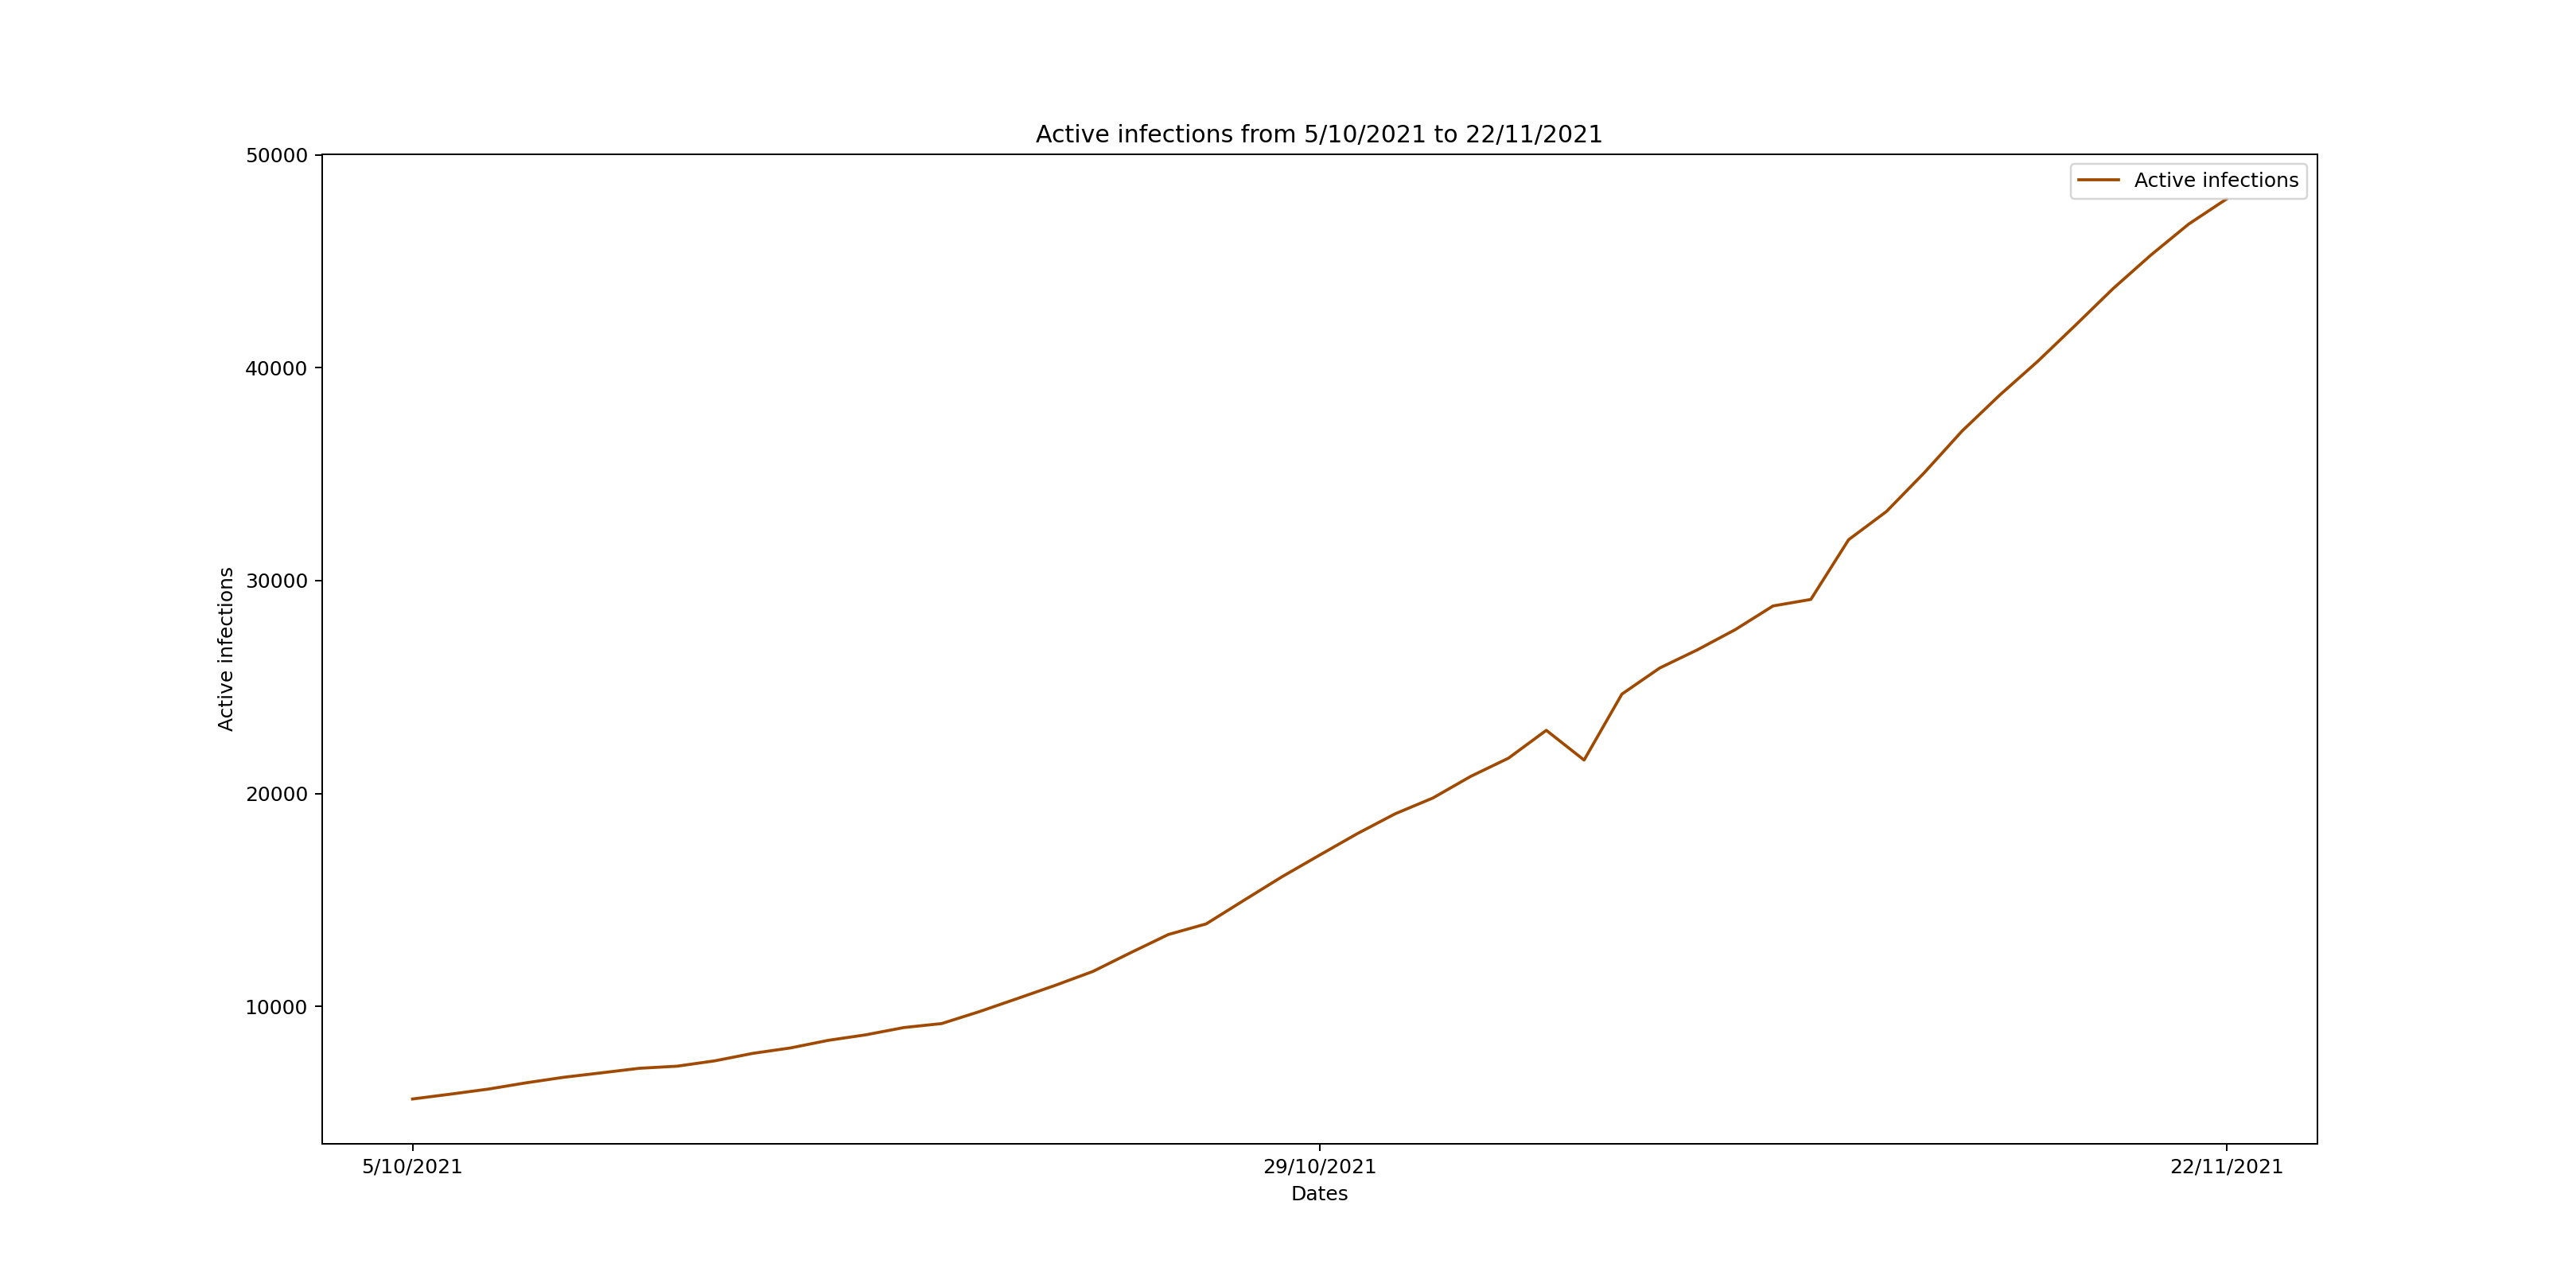

In [70]:
if not os.path.exists('./Images'):
    os.makedirs('./Images')
    
date_range_column = get_range('5/10/2021', '22/11/2021', date_full_column, date_full_column)

s_range_column = get_range('27/2/2020', '18/4/2020', s_full_column, date_full_column)
i_range_column = get_range('5/10/2021', '22/11/2021', i_full_column, date_full_column)
r_range_column = get_range('27/2/2020', '18/11/2021', r_full_column, date_full_column)
    
x_ticks_full = [date_full_column[0], date_full_column[int(len(date_full_column) / 2)], date_full_column[-1]]
xticks = [date_range_column[0], date_range_column[int(len(date_range_column) / 2)], date_range_column[-1]]
    
# # Susceptible
# plt.figure(figsize = (10, 5))
# plt.title('Susceptibles')
# plt.plot(date_range_column, s_range_column, '-', label = 'Susceptible', color = '#154F7C')
# plt.legend()

# plt.ylabel('Susceptibles')
# plt.xlabel('Dates')
# plt.xticks(xticks)

# plt.savefig('./Images/full_susceptibles.png')

# plt.show()

# Active infections
plt.figure(figsize = (10, 5))
plt.title('Active infections from 5/10/2021 to 22/11/2021')
plt.plot(date_range_column, i_range_column, '-', label = 'Active infections', color = '#9F4A00')
plt.legend()

plt.ylabel('Active infections')
plt.xlabel('Dates')
plt.xticks(xticks)

plt.savefig('./Images/full_active_infections.png')

plt.show()

# # Recovered
# plt.figure(figsize = (20, 10))
# plt.title('Recovered')
# plt.plot(date_range_column, r_range_column, '-', label = 'Recovered', color = '#1A5F1A')
# plt.legend()

# plt.ylabel('Recovered')
# plt.xlabel('Dates')
# plt.xticks(xticks)

# plt.savefig('./Images/full_recovered.png')

# plt.show()

# # SSI
# plt.figure(figsize = (20, 10))
# plt.title('Susceptibles, Active Infections and Recovered')
# plt.plot(date_range_column, s_range_column, '-', label = 'Susceptible', color = '#154F7C')
# plt.plot(date_range_column, i_range_column, '-', label = 'Active infections', color = '#9F4A00')
# plt.plot(date_range_column, r_range_column, '-', label = 'Recovered', color = '#1A5F1A')
# plt.legend()

# plt.ylabel('Population count')
# plt.xlabel('Dates')
# plt.xticks(xticks)

# plt.savefig('./Images/full.png')

# plt.show()

# x_ticks_tests = [date_full_column[0], date_full_column[int(len(date_full_column) / 2)], date_full_column[-1]]

# # COVID-19 Tests
# plt.figure(figsize = (15, 5))
# plt.title('Daily tests for COVID-19 in Denmark')
# plt.plot(date_full_column, test_full_column, '-', label = 'Daily tests')
# plt.legend()

# plt.ylabel('Daily tests')
# plt.xlabel('Dates')
# plt.xticks(x_ticks_tests)

# plt.savefig('./Images/full_tests_whole.png')

# plt.show()